In [102]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score, completeness_score, v_measure_score
from scipy.spatial.distance import cdist
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.model_selection import StratifiedKFold
import itertools
from scipy import linalg
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier

def get_time_as_float(dt):
    ls = re.findall(r'[0-9]+', dt)
    ret = datetime(*[int(i) for i in ls]).timestamp()
    return ret

def transform_data(ls):
    ret = []
    for i in range(len(ls)):
        ret.append(get_time_as_float(ls[i]) if i == 0 else float(ls[i]))
    return ret

# Load Digit Data
data, target = load_digits(return_X_y = True)

# Load Occupancy Data
f = open('datatraining.txt', 'r')
lines = [line.strip().split(',')[1:] for line in f.readlines()[1:]]
occData, occTarget = [line[:-1] for line in lines], [line[-1] for line in lines]
f.close()

data = scale(data)
occData = np.array([transform_data(ls) for ls in occData])


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


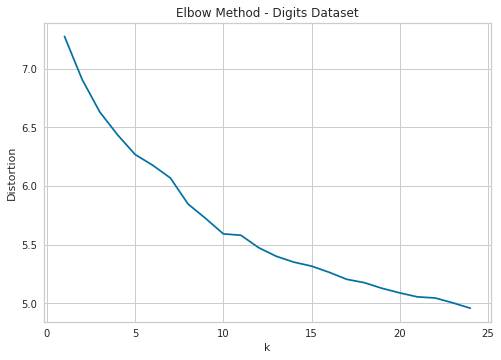

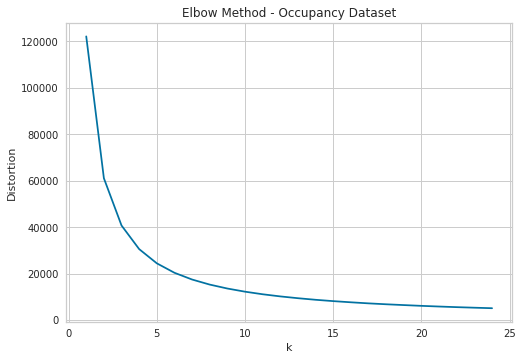

In [2]:
# Determine Best K for each Dataset using Elbow Method

# Digits Dataset
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=5).fit(data)
    kmeanModel.fit(data)
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    
plt.plot([k for k in K], distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method - Digits Dataset")
plt.show()

# Occupancy Dataset
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(occData)
    kmeanModel.fit(occData)
    distortions.append(sum(np.min(cdist(occData, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / occData.shape[0])
    
plt.plot([k for k in K], distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method - Occupancy Dataset")
plt.show()

In [143]:
def show_silhouette(range_n_clusters, data, clf):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
#         clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#         cluster_labels = clusterer.fit_predict(data)
        param_dict = {'n_clusters': n_clusters, 'random_state': 5}
        clf.set_params(**param_dict)
        clusterer = clf
        cluster_labels = clf.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

[0.1070451725825343, 0.1058389334495898, 0.09462083924174257, 0.10037569328330705, 0.11188035145690323, 0.11659653689432985, 0.12561178508758536, 0.13362052049327852, 0.14424582820484047, 0.14824133847148813, 0.1540340410109958, 0.144791498954701, 0.14895416841256612, 0.14426375852588752, 0.14846002338029105, 0.15327645670172305, 0.15520575154516852, 0.15596247829847304, 0.15629124577708575, 0.15845156767585344, 0.15580227082724332, 0.15660792485728053, 0.16257283067316985]


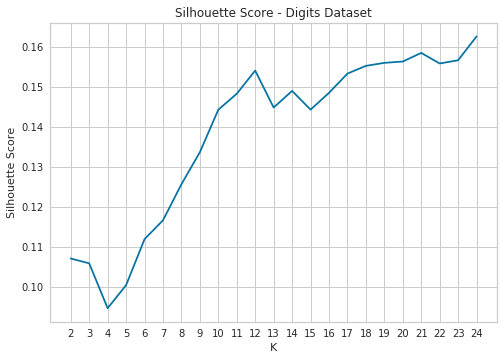

In [6]:
# Record Silhouette Scores and print Graphs for Digit Data
clf = KMeans()
# show_silhouette(range(2, 25), data, clf)

silscores = []
for i in range(2, 25):
    clf = KMeans(random_state=5, n_clusters=i)
    labels = clf.fit_predict(data)
    silscores.append(silhouette_score(data, labels))
    

print(silscores)

plt.plot([str(i) for i in range(2, 25)], silscores)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score - Digits Dataset")
plt.show()

In [11]:
# KMeans - Digit Data - Homogeneity score
clf = KMeans(random_state=5, n_clusters=12)
clf.fit(data)
print(homogeneity_score(target, clf.labels_))
print(completeness_score(target, clf.labels_))
print(v_measure_score(target, clf.labels_))


0.6644903463736622
0.6774043918174198
0.6708852283906941


[0.6266330553536087, 0.5900242171895371, 0.5716936486899712, 0.5605814877219297, 0.5531491392923574, 0.5479031850429719, 0.5436997705685014, 0.5406144312511174, 0.538791800067252, 0.536105936769228, 0.5347073853423975, 0.5327635383695226, 0.5317909378788909, 0.5312244717255218, 0.5296134376074978, 0.5284155758070707, 0.528467757590142, 0.5270696043437281, 0.5269193844788818, 0.5263205600663737, 0.5250356314578117, 0.5247643192285276, 0.5247646468536882]


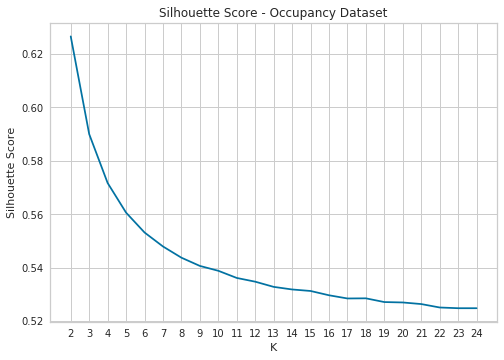

In [144]:
# Record Silhouette Scores and print Graphs for Occupancy Data
clf = KMeans()
# show_silhouette(range(2, 25), data, clf)

silscores = []
for i in range(2, 25):
    clf = KMeans(random_state=5, n_clusters=i)
    labels = clf.fit_predict(occData)
    silscores.append(silhouette_score(occData, labels))
    

print(silscores)

plt.plot([str(i) for i in range(2, 25)], silscores)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score - Occupancy Dataset")
plt.show()

In [153]:
# KMeans - Occupancy Data - Homogeneity score
clf = KMeans(random_state=5, n_clusters=10)
clf.fit(data)
print(homogeneity_score(target, clf.labels_))
print(completeness_score(target, clf.labels_))
print(v_measure_score(target, clf.labels_))


0.6745810512278679
0.7154785411736135
0.694428165632884


In [159]:
# Perform Clustering using GaussianMixture
K = range(2, 25)
cv = ['spherical', 'tied', 'diag', 'full']
# Digits Dataset
best_bic = np.infty
best_combo = None
digit_gm = None
for combo in itertools.product(K, cv):
    gm = GaussianMixture(n_components=combo[0], random_state=5, covariance_type=combo[1])
    gm.fit(data)
    bic = gm.bic(data)
    if bic < best_bic:
        best_bic = bic
        best_combo = combo
        digit_gm = gm


print(best_bic)
print(best_combo)

best_bic = np.infty
best_combo = None
occ_gm = None
for combo in itertools.product(K, cv):
    gm = GaussianMixture(n_components=combo[0], random_state=5, covariance_type=combo[1])
    gm.fit(occData)
    bic = gm.bic(occData)
    if bic < best_bic:
        best_bic = bic
        best_combo = combo
        occ_gm = gm
        
print(best_bic)
print(best_combo)



-229813.38681244163
(22, 'diag')
137594.74957797796
(24, 'full')


In [160]:
# Perform Metrics on Digits Clusters from Gaussian Mixture
digit_gm.fit(data)
y_pred = digit_gm.predict(data)

print("Digits Dataset: Homogeneity, Completeness, V-Measure")
print(homogeneity_score(target, y_pred))
print(completeness_score(target, y_pred))
print(v_measure_score(target, y_pred))

# Perform Metrics on Occupancy Clusters from Gaussian Mixture
occ_gm.fit(occData)
y_pred = occ_gm.predict(occData)
print("Occupancy Dataset: Homogeneity, Completeness, V-Measure")
print(homogeneity_score(occTarget, y_pred))
print(completeness_score(occTarget, y_pred))
print(v_measure_score(occTarget, y_pred))

Digits Dataset: Homogeneity, Completeness, V-Measure
0.6603967448417006
0.5322293079073834
0.5894261686489176
Occupancy Dataset: Homogeneity, Completeness, V-Measure
0.8476008960644278
0.145068388535684
0.24773627636318318


In [191]:
# Dimensionality Reduction - Digit Data
# Perform Principal Component Analysis

# Find Variance over all Components
pca = PCA(random_state=5)
pca.fit(data)
for i in range(len(pca.explained_variance_ratio_)):
    print(i)
    print(sum(pca.explained_variance_ratio_[:i]))

# Use 33 attributes which has 91% of variance and transform data
pca = PCA(random_state=5, n_components=33).fit(data)
digit_data_pca = pca.transform(data)


# Linear Discriminant Analysis
lda = LDA()
lda.fit(data, target)
lda.explained_variance_ratio_

lda = LDA()
lda.fit(data, target)
digits_lda = lda.transform(data)



0
0
1
0.12033916097734884
2
0.21594970500832766
3
0.30039385393457296
4
0.3653779330098146
5
0.4139794817694787
6
0.45612068046219817
7
0.4955415084978718
8
0.5294353177442551
9
0.5594175278605075
10
0.5887375533730297
11
0.6165556080085329
12
0.642326158934353
13
0.6650791920919955
14
0.687350989487139
15
0.7090032838056315
16
0.7281449498700528
17
0.7459004207217348
18
0.762281113464579
19
0.7782457151532025
20
0.7931376270240807
21
0.8066173226822602
22
0.8193366363846077
23
0.8309950098905272
24
0.8415714758758904
25
0.8513246353478715
26
0.8607702252451915
27
0.8694003635148988
28
0.8777667920515839
29
0.8857437245356964
30
0.893208438244957
31
0.9004642597586597
32
0.9073833722134715
33
0.9139224575691978
34
0.9203303833076576
35
0.9262442244248811
36
0.9319558484771163
37
0.9371922165112827
38
0.9420102923757341
39
0.9465474849743186
40
0.9507791125066464
41
0.9548396432064368
42
0.958810491289195
43
0.9623754243206212
44
0.9657832961353242
45
0.9690616494882037
46
0.97217196956

In [192]:
# Dimensionality Reduction - Occupancy
# Perform Principal Component Analysis

# Find Variance over all Components
pca = PCA(random_state=5)
pca.fit(occData)
for i in range(len(pca.explained_variance_ratio_)):
    print(i)
    print(sum(pca.explained_variance_ratio_[:i]))

# Use 2 attributes which has 99% of variance and transform data
pca = PCA(random_state=5, n_components=2).fit(occData)
occ_pca = pca.transform(occData)


# Linear Discriminant Analysis
lda = LDA()
lda.fit(occData, occTarget)
occ_lda = lda.transform(occData)



0
0
1
0.9999932292572888
2
0.9999991900751296
3
0.9999999993330421
4
0.9999999999812623
5
0.9999999999999999


[0.12015371419584345, 0.11743142856785604, 0.10705489133724035, 0.11755585072760333, 0.12838007521344408, 0.13129726563579516, 0.1488752323602966, 0.15765887625973019, 0.16921656169652255, 0.17143067486023258, 0.17325995185988172, 0.18372452586073032, 0.17281238034244642, 0.17582703244774878, 0.17589305177809456, 0.17536178397734198, 0.18010196787092272, 0.16675534857016872, 0.16852179499693057, 0.16937435345772436, 0.17266752082397002, 0.17475811633613889, 0.17746611162398906]


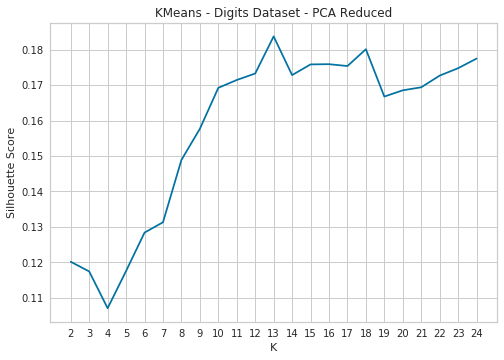

[0.6266327717476977, 0.5900158510441383, 0.5716985850046409, 0.5605419847765628, 0.5530374529587391, 0.5478781620607461, 0.543482043771365, 0.5404249243371545, 0.5389313745191093, 0.5359351179639641, 0.5346328388677052, 0.5326675837062069, 0.5317918558058143, 0.5300557660222557, 0.529453268515277, 0.528062384607796, 0.5284747754660571, 0.5264605397725401, 0.5268523076979589, 0.5262570753055513, 0.5247933052011493, 0.5246685437054354, 0.524674539457083]


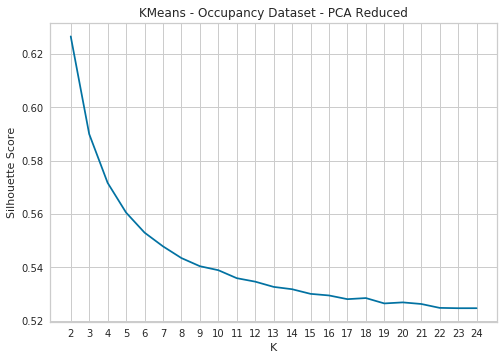

In [180]:
# Clustering on PCA Reduced Digits Dataset

# KMeans - PCA
silscores = []
for i in range(2, 25):
    clf = KMeans(random_state=5, n_clusters=i)
    labels = clf.fit_predict(digit_data_pca)
    silscores.append(silhouette_score(digit_data_pca, labels))
    

print(silscores)

plt.plot([str(i) for i in range(2, 25)], silscores)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("KMeans - Digits Dataset - PCA Reduced")
plt.show()

# KMeans - PCA
silscores = []
for i in range(2, 25):
    clf = KMeans(random_state=5, n_clusters=i)
    labels = clf.fit_predict(occ_pca)
    silscores.append(silhouette_score(occ_pca, labels))
    

print(silscores)

plt.plot([str(i) for i in range(2, 25)], silscores)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("KMeans - Occupancy Dataset - PCA Reduced")
plt.show()



# # KMeans - LDA
# silscores = []
# for i in range(2, 25):
#     clf = KMeans(random_state=5, n_clusters=i)
#     labels = clf.fit_predict(digits_lda)
#     silscores.append(silhouette_score(digits_lda, labels))
    

# print(silscores)

# plt.plot([str(i) for i in range(2, 25)], silscores)
# plt.xlabel("K")
# plt.ylabel("Silhouette Score")
# plt.title("KMeans - Digits Dataset - LDA Reduced")
# plt.show()

# # Gaussian Mixture - PCA
# silscores = []
# for i in range(2, 25):
#     clf = GaussianMixture(random_state=5, n_components=i)
#     labels = clf.fit_predict(digit_data_pca)
#     silscores.append(silhouette_score(digit_data_pca, labels))
    
# print(silscores)

# plt.plot([str(i) for i in range(2, 25)], silscores)
# plt.xlabel("K")
# plt.ylabel("Silhouette Score")
# plt.title("Gaussian Mixture - Digits Dataset - PCA Reduced")
# plt.show()

# # Gaussian Mixture - LDA

# silscores = []
# for i in range(2, 25):
#     clf = KMeans(random_state=5, n_clusters=i)
#     labels = clf.fit_predict(digits_lda)
#     silscores.append(silhouette_score(digits_lda, labels))
    

# print(silscores)

# plt.plot([str(i) for i in range(2, 25)], silscores)
# plt.xlabel("K")
# plt.ylabel("Silhouette Score")
# plt.title("Gaussian Mixture - Digits Dataset - LDA Reduced")
# plt.show()


In [181]:
# KMeans - PCA Data - Evaluation

# KMeans PCA - Digits
clf = KMeans(random_state=5, n_clusters=10)
clf.fit(digit_data_pca)
print(homogeneity_score(target, clf.labels_))
print(completeness_score(target, clf.labels_))
print(v_measure_score(target, clf.labels_))
print()
# KMeans PCA - Occupancy

clf = KMeans(random_state=5, n_clusters=3)
clf.fit(occ_pca)
print(homogeneity_score(occTarget, clf.labels_))
print(completeness_score(occTarget, clf.labels_))
print(v_measure_score(occTarget, clf.labels_))
print()

0.6026868673551895
0.6505350432797132
0.6256975305201845

0.07855387942351941
0.03696937893577785
0.05027711608083762



In [182]:
# Expectation-Maximization - PCA Data

K = range(2, 25)
cv = ['spherical', 'tied', 'diag', 'full']
# Digits Dataset
best_bic = np.infty
best_combo = None
digit_gm = None
for combo in itertools.product(K, cv):
    gm = GaussianMixture(n_components=combo[0], random_state=5, covariance_type=combo[1])
    gm.fit(digit_data_pca)
    bic = gm.bic(digit_data_pca)
    if bic < best_bic:
        best_bic = bic
        best_combo = combo
        digit_gm = gm


print(best_bic)
print(best_combo)

# Occupancy Dataset
best_bic = np.infty
best_combo = None
occ_gm = None
for combo in itertools.product(K, cv):
    gm = GaussianMixture(n_components=combo[0], random_state=5, covariance_type=combo[1])
    gm.fit(occ_pca)
    bic = gm.bic(occ_pca)
    if bic < best_bic:
        best_bic = bic
        best_combo = combo
        occ_gm = gm
        
print(best_bic)
print(best_combo)



89784.51564074928
(6, 'full')
281576.2035425172
(24, 'full')


In [183]:
# Perform Metrics on Clusters from Gaussian Mixture
digit_gm.fit(digit_data_pca)
y_pred = digit_gm.predict(digit_data_pca)

print("Digits Dataset: Homogeneity, Completeness, V-Measure")
print(homogeneity_score(target, y_pred))
print(completeness_score(target, y_pred))
print(v_measure_score(target, y_pred))

# Perform Metrics on Occupancy Clusters from Gaussian Mixture
occ_gm.fit(occ_pca)
y_pred = occ_gm.predict(occ_pca)
print("Occupancy Dataset: Homogeneity, Completeness, V-Measure")
print(homogeneity_score(occTarget, y_pred))
print(completeness_score(occTarget, y_pred))
print(v_measure_score(occTarget, y_pred))

Digits Dataset: Homogeneity, Completeness, V-Measure
0.522977812799803
0.7850398678183925
0.6277567025520193
Occupancy Dataset: Homogeneity, Completeness, V-Measure
0.8029170625006644
0.1362011870914909
0.23289560626916986


[0.22035321943732095, 0.19083989675004154, 0.2524049568002482, 0.2808550953728587, 0.3088557449902067, 0.33936439821684294, 0.37201305092107473, 0.38219313208294603, 0.3958697347079846, 0.3762324010698296, 0.3556054759186346, 0.3312985343295381, 0.3179953373941559, 0.302835423046228, 0.2951127860352386, 0.28098110418028177, 0.24541290682787606, 0.23645589713920404, 0.1668430444480953, 0.21708705626055566, 0.216587832052232, 0.1681051294598326, 0.20490787783208855]


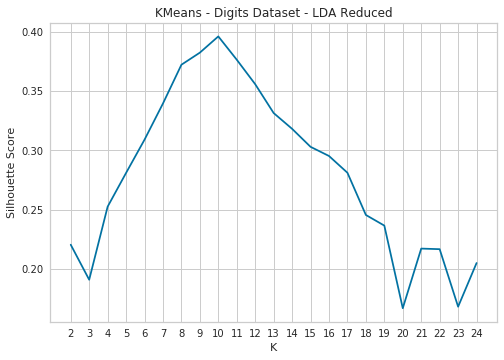

[0.8889707611627197, 0.7863684083023178, 0.7373979346819286, 0.6009042218702717, 0.6015664879902178, 0.6345971818736951, 0.6283787175195448, 0.6268987004208525, 0.6268220704438218, 0.6265255937310951, 0.5725105853993689, 0.5712594824320181, 0.5723782839792421, 0.5800887011217293, 0.5765847427914356, 0.5733810128961926, 0.573317808020348, 0.5589806910786842, 0.5539166051321611, 0.5490010211828471, 0.550973946435835, 0.5597925768274787, 0.5590646984209816]


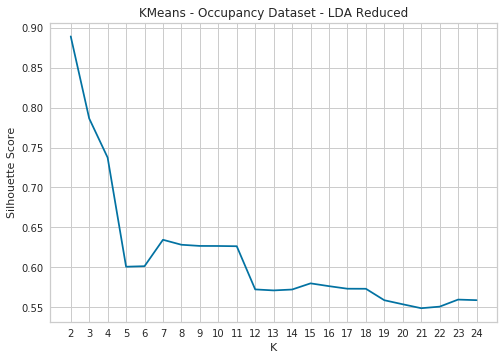

In [193]:
# Clustering on LDA Reduced Datasets

# KMeans - LDA
silscores = []
for i in range(2, 25):
    clf = KMeans(random_state=5, n_clusters=i)
    labels = clf.fit_predict(digits_lda)
    silscores.append(silhouette_score(digits_lda, labels))
    

print(silscores)

plt.plot([str(i) for i in range(2, 25)], silscores)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("KMeans - Digits Dataset - LDA Reduced")
plt.show()

# KMeans - LDA
silscores = []
for i in range(2, 25):
    clf = KMeans(random_state=5, n_clusters=i)
    labels = clf.fit_predict(occ_lda)
    silscores.append(silhouette_score(occ_lda, labels))
    

print(silscores)

plt.plot([str(i) for i in range(2, 25)], silscores)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("KMeans - Occupancy Dataset - LDA Reduced")
plt.show()


In [196]:
# KMeans - LDA Data - Evaluation

# KMeans LDA - Digits
clf = KMeans(random_state=5, n_clusters=10)
clf.fit(digits_lda)
print(homogeneity_score(target, clf.labels_))
print(completeness_score(target, clf.labels_))
print(v_measure_score(target, clf.labels_))
print()
# KMeans PCA - Occupancy

clf = KMeans(random_state=5, n_clusters=2)
clf.fit(occ_lda)
print(homogeneity_score(occTarget, clf.labels_))
print(completeness_score(occTarget, clf.labels_))
print(v_measure_score(occTarget, clf.labels_))
print()

clf = KMeans(random_state=5, n_clusters=3)
clf.fit(occ_lda)
print(homogeneity_score(occTarget, clf.labels_))
print(completeness_score(occTarget, clf.labels_))
print(v_measure_score(occTarget, clf.labels_))
print()

clf = KMeans(random_state=5, n_clusters=5)
clf.fit(occ_lda)
print(homogeneity_score(occTarget, clf.labels_))
print(completeness_score(occTarget, clf.labels_))
print(v_measure_score(occTarget, clf.labels_))
print()

clf = KMeans(random_state=5, n_clusters=6)
clf.fit(occ_lda)
print(homogeneity_score(occTarget, clf.labels_))
print(completeness_score(occTarget, clf.labels_))
print(v_measure_score(occTarget, clf.labels_))
print()

0.917571927755351
0.9177410022605721
0.9176564572201376

0.9036012918782598
0.877548150277036
0.8903841794613104

0.90879561963713
0.6430861403515239
0.7531938095658608

0.9078996630796199
0.38114136467421034
0.536892324019194

0.9092705504546297
0.38071166840537035
0.5367049300902353



In [194]:
# Expectation-Maximization - LDA Data

K = range(2, 25)
cv = ['spherical', 'tied', 'diag', 'full']
# Digits Dataset
best_bic = np.infty
best_combo = None
digit_gm = None
for combo in itertools.product(K, cv):
    gm = GaussianMixture(n_components=combo[0], random_state=5, covariance_type=combo[1])
    gm.fit(digits_lda)
    bic = gm.bic(digits_lda)
    if bic < best_bic:
        best_bic = bic
        best_combo = combo
        digit_gm = gm


print(best_bic)
print(best_combo)

# Occupancy Dataset
best_bic = np.infty
best_combo = None
occ_gm = None
for combo in itertools.product(K, cv):
    gm = GaussianMixture(n_components=combo[0], random_state=5, covariance_type=combo[1])
    gm.fit(occ_lda)
    bic = gm.bic(occ_lda)
    if bic < best_bic:
        best_bic = bic
        best_combo = combo
        occ_gm = gm
        
print(best_bic)
print(best_combo)



53484.93800685037
(23, 'spherical')
19113.08443407934
(15, 'full')


In [197]:
# Perform Metrics on Clusters from Gaussian Mixture
digit_gm.fit(digits_lda)
y_pred = digit_gm.predict(digits_lda)

print("Digits Dataset: Homogeneity, Completeness, V-Measure")
print(homogeneity_score(target, y_pred))
print(completeness_score(target, y_pred))
print(v_measure_score(target, y_pred))

# Perform Metrics on Occupancy Clusters from Gaussian Mixture
occ_gm.fit(occ_lda)
y_pred = occ_gm.predict(occ_lda)
print("Occupancy Dataset: Homogeneity, Completeness, V-Measure")
print(homogeneity_score(occTarget, y_pred))
print(completeness_score(occTarget, y_pred))
print(v_measure_score(occTarget, y_pred))

Digits Dataset: Homogeneity, Completeness, V-Measure
0.9254747152547084
0.7004978841771938
0.797421900125403
Occupancy Dataset: Homogeneity, Completeness, V-Measure
0.9119275659825907
0.22802738793279428
0.36482925950836487
